# NRV Demo notebook n. 1
# BIOCAS 2024

Welcome to NRV's demonstration. If you are here, you should be trying to test the framework online on your internet browser, please relax and let's explore what you can do with it.

## What we will do in this demo
Here we demonstrate the basic functionality of NRV on a single axonal fiber and explore conventional and kHz (propagation block) stimulation waveforms. Basically the geometry of the problem will be simple: a single unmyelinated fiber is considered (diameter $D = 1\mu m$ and a length of $5mm$). A point-source (i.e. infinitely small) electrode will be placed in the middle of the axon, placed $100\mu m$ far away from the center of the fiber.

We will stimulate with:
1. A $60\mu s$ square pulse (conventional) cathodic (negative) stimulation, charged balanced. This waveform will induce an activity that should propagate in both direction along the fiber (so we will check the results with extra care!)
2. A $10kHz$ sinusoidal stimulation as performed in propagation block. As with should observe the block, we will have to force the generation of an action potential at one side of the fiber and observe if it crosses the nearest position to the electrode or not.

Let's dive into this scenario

## Importing the framework and general philosophy
NRV is a pythonic librairy, so it is designed using Object Oriented Programming concepts: the user deals with instances of objects defined in classes, on which methods are applied. To describe the electro-physiological setup, software objects are directly the same as the physical objects. We will load the framework and then use a `axon`-object as well as a `electrode`-object. We defined two different waveforms, so you can easily guess we will also need to define two `waveform`-object instances. The electrode is in a physical material, look at the code there is also a given object for that. The rest of the following code (variables) is just here for clarity:


In [34]:
import nrv
import matplotlib.pyplot as plt

y = 0                       # axon y position, in [um]
z = 0                       # axon z position, in [um]
d = 1                       # axon diameter, in [um]
L = 5000                    # axon length, along x axis, in [um]
axon1 = nrv.unmyelinated(y,z,d,L)

# material properties
epineurium = nrv.load_material('endoneurium_bhadra')

# electrode
x_elec = L/2                # electrode x position, in [um]
y_elec = 100                # electrode y position, in [um]
z_elec = 0                  # electrode y position, in [um]
E1 = nrv.point_source_electrode(x_elec,y_elec,z_elec)

# stimulus
start = 2
I_cathod = 500
I_anod = I_cathod/5
T_cathod = 60e-3
T_inter = 40e-3
stim1 = nrv.stimulus()
stim1.biphasic_pulse(start, I_cathod, T_cathod, I_anod, T_inter)

# material properties
epineurium = nrv.load_material('endoneurium_bhadra')


Simple so far, isn't it? Oh... I just forgot to tell you that we need to connect all those guys. But guess what, there is an object for that:

In [35]:
# extracellular stimulation setup
extra_stim = nrv.stimulation(epineurium)
extra_stim.add_electrode(E1, stim1)
axon1.attach_extracellular_stimulation(extra_stim)

## First result
The only thing left is the simulation itself, and just a bit of postprocessing:

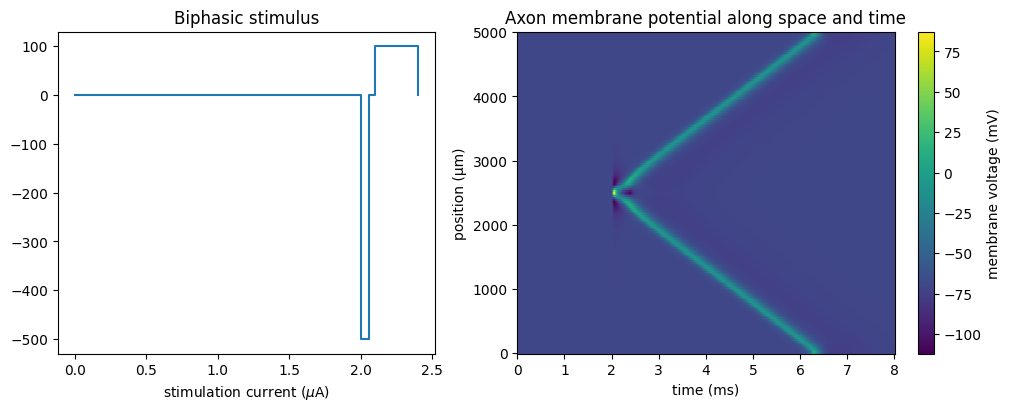

In [36]:
results = axon1.simulate(t_sim=8)
# del axon1

fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(10, 4))

stim1.plot(axs[0])
axs[0].set_title('Biphasic stimulus')
axs[0].set_xlabel('time (ms)')
axs[0].set_xlabel('stimulation current ($\mu$A)')

map = axs[1].pcolormesh(results['t'], results['x_rec'], results['V_mem'] ,shading='auto')
axs[1].set_title('Axon membrane potential along space and time')
axs[1].set_xlabel('time (ms)')
axs[1].set_ylabel('position (µm)')
cbar = plt.colorbar(map)
cbar.set_label('membrane voltage (mV)')

plt.show()

There it is: on the left of the figure, you can observe the biphasic stimulus. No value is continued after the last '0' in the signal as by default the last numerical value for a stimulation is used if undefined. On the right, the membrane potential along the position in the axon (*y-axis*) is plotted versus time (*x-axis*). Near the mid-position ($2500\mu m$) a local depolarization can be observed, leading to a propagating action potential (positive potential in yellow color), that effectively propagates to both directions.

## Propagation block
Now that we see the expected  result for conventional stimulation, let's dive into the kHz stimulation waveform case. The code above is almost OK, however we should change the stimulation waveform. The following line get just rid of the conventional one, and reset the `stimulation`-object:

In [37]:
del stim1
extra_stim.reset_stimuli()
extra_stim.reset_electrodes()


So let's start fresh on the new waveform, a sinusoid starting also at $t=2ms$ :

In [38]:
stim1 = nrv.stimulus()

#stimulus Block
block_start=2                                               #KES block start in ms
block_amp=1000                                               #KES block amplitude in uA
block_freq=10                                               #KES block frequency in kHz
block_duration=20                                           #KES duration
stim1.sinus(block_start, block_duration, block_amp, block_freq)

# Link everyone with the stimulation
extra_stim.add_electrode(E1, stim1)
axon1.attach_extracellular_stimulation(extra_stim)


Again, almost done ! We just need to add the clamp to test the setup with a traveling action potential. This can be obtained as a method of the `axon`-object that you can clamp (current or voltage):

In [39]:
## Intracellular stimulation definition
t_start = 10               # starting time, in [ms]
duration = 0.25             # duration, in [ms]
amplitude = 3               # amplitude, in [nA]
relative_position = 0.0
axon1.insert_I_Clamp(relative_position, t_start, duration, amplitude)

The only missing part is the second simulation and ploting stimuli and results:

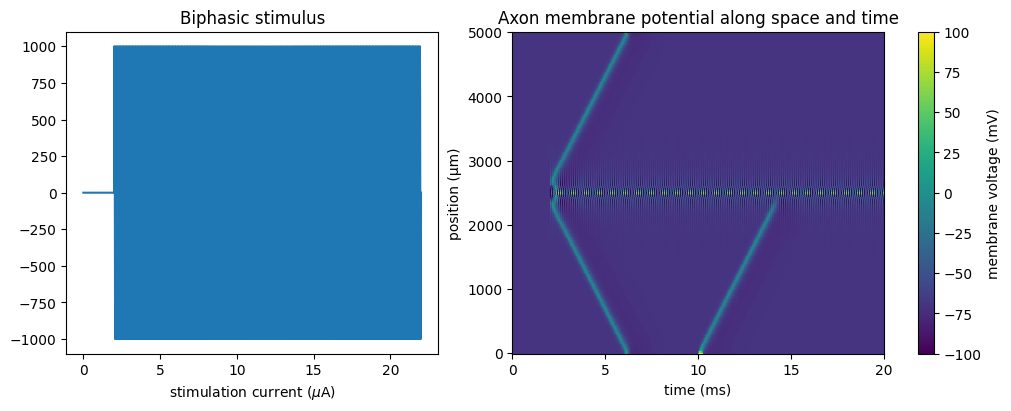

In [40]:
results = axon1.simulate(t_sim=20)
# del axon1

fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(10, 4))

stim1.plot(axs[0])
axs[0].set_title('Biphasic stimulus')
axs[0].set_xlabel('time (ms)')
axs[0].set_xlabel('stimulation current ($\mu$A)')

map = axs[1].pcolormesh(results['t'], results['x_rec'], results['V_mem'] ,shading='auto', vmin=-100, vmax = 100)
axs[1].set_title('Axon membrane potential along space and time')
axs[1].set_xlabel('time (ms)')
axs[1].set_ylabel('position (µm)')
cbar = plt.colorbar(map)
cbar.set_label('membrane voltage (mV)')

plt.show()

Near to the electrode, it is possible to see the oscillation at $10kHz$ resulting from the stimulation artifact. At the stimulation start timing, a spike is generated and propagates on both directions. This phenomenon is typical of propagation block and is called the onset response. The test spike start at $t=10ms$ and from position 0. It propagates and vanishes near the stimulation artifact, no spike is visible on higher positions that the electrode's one. So this is the expected result: propagation block.

We hope this first demonstration was instructive for you. It is possible to do much more detailed things with NRV, which will be demonstrated in the next demo files, but there is the general way it works: Object-Oriented, with names that should be understandable for researchers or student that have a basic understanding of electrophysiology, and fast to simulate.

**For more details and help:**
- **Documentation:** https://nrv.readthedocs.io/en/latest/
- **Forum:** https://nrv-framework.org/forum

**Please, don't be shy and contact us if you have trouble using NRV, we will be happy to help!**
